# Intro

Using dataset from http://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29, the goal of this work is to use machine learning and find the better model for classification.

In [1]:
# Import the libraries used
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

Using TensorFlow backend.


In [2]:
# Import the dataset
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'
attribute = ['existingchecking', 'duration', 'credithistory', 'purpose', 'creditamount', 
         'savings', 'employmentsince', 'installmentrate', 'statussex', 'otherdebtors', 
         'residencesince', 'property', 'age', 'otherinstallmentplans', 'housing', 
         'existingcredits', 'job', 'people', 'telephone', 'foreignworker', 'classification']
data = pd.read_table(url, delimiter=' ', names = attribute)
print(data.shape)
print (data.columns)
data.head(10)

(1000, 21)
Index(['existingchecking', 'duration', 'credithistory', 'purpose',
       'creditamount', 'savings', 'employmentsince', 'installmentrate',
       'statussex', 'otherdebtors', 'residencesince', 'property', 'age',
       'otherinstallmentplans', 'housing', 'existingcredits', 'job', 'people',
       'telephone', 'foreignworker', 'classification'],
      dtype='object')


,existingchecking,duration,credithistory,purpose,creditamount,savings,employmentsince,installmentrate,statussex,otherdebtors,...,property,age,otherinstallmentplans,housing,existingcredits,job,people,telephone,foreignworker,classification
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
5,A14,36,A32,A46,9055,A65,A73,2,A93,A101,...,A124,35,A143,A153,1,A172,2,A192,A201,1
6,A14,24,A32,A42,2835,A63,A75,3,A93,A101,...,A122,53,A143,A152,1,A173,1,A191,A201,1
7,A12,36,A32,A41,6948,A61,A73,2,A93,A101,...,A123,35,A143,A151,1,A174,1,A192,A201,1
8,A14,12,A32,A43,3059,A64,A74,2,A91,A101,...,A121,61,A143,A152,1,A172,1,A191,A201,1
9,A12,30,A34,A40,5234,A61,A71,4,A94,A101,...,A123,28,A143,A152,2,A174,1,A191,A201,2


In [3]:
# List of categorical variables labels
catvars = ['existingchecking', 'credithistory', 'purpose', 'savings', 'employmentsince',
           'statussex', 'otherdebtors', 'property', 'otherinstallmentplans', 'housing', 'job', 
           'telephone', 'foreignworker']

# List of numerical variables labels
numvars = ['creditamount', 'duration', 'installmentrate', 'residencesince', 'age', 
           'existingcredits', 'people', 'classification']

In [4]:
# Print the number of 'classification' feature
data.classification.value_counts()

1    700
2    300
Name: classification, dtype: int64

In [5]:
# Binarize the y output for easier use -> 0 = bad; 1 = good
data.classification.replace([1,2], [1,0], inplace=True)
# Print the number of updated feature
data.classification.value_counts()

1    700
0    300
Name: classification, dtype: int64

# Exploratory Data Analysis (EDA)

## Continuous Attributes

Text(0.5, 1.0, 'age')

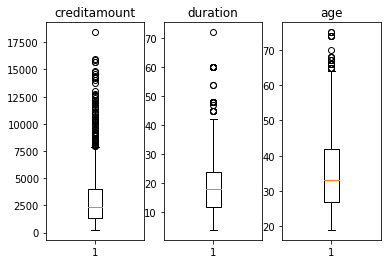

In [6]:
# Boxplots for continuous attributes
fig, axes = plt.subplots(nrows=1, ncols=3)
axes[0].boxplot(data['creditamount'])
axes[0].set_title('creditamount')
axes[1].boxplot(data['duration'])
axes[1].set_title('duration')
axes[2].boxplot(data['age'])
axes[2].set_title('age')

## Non-continuous Attributes

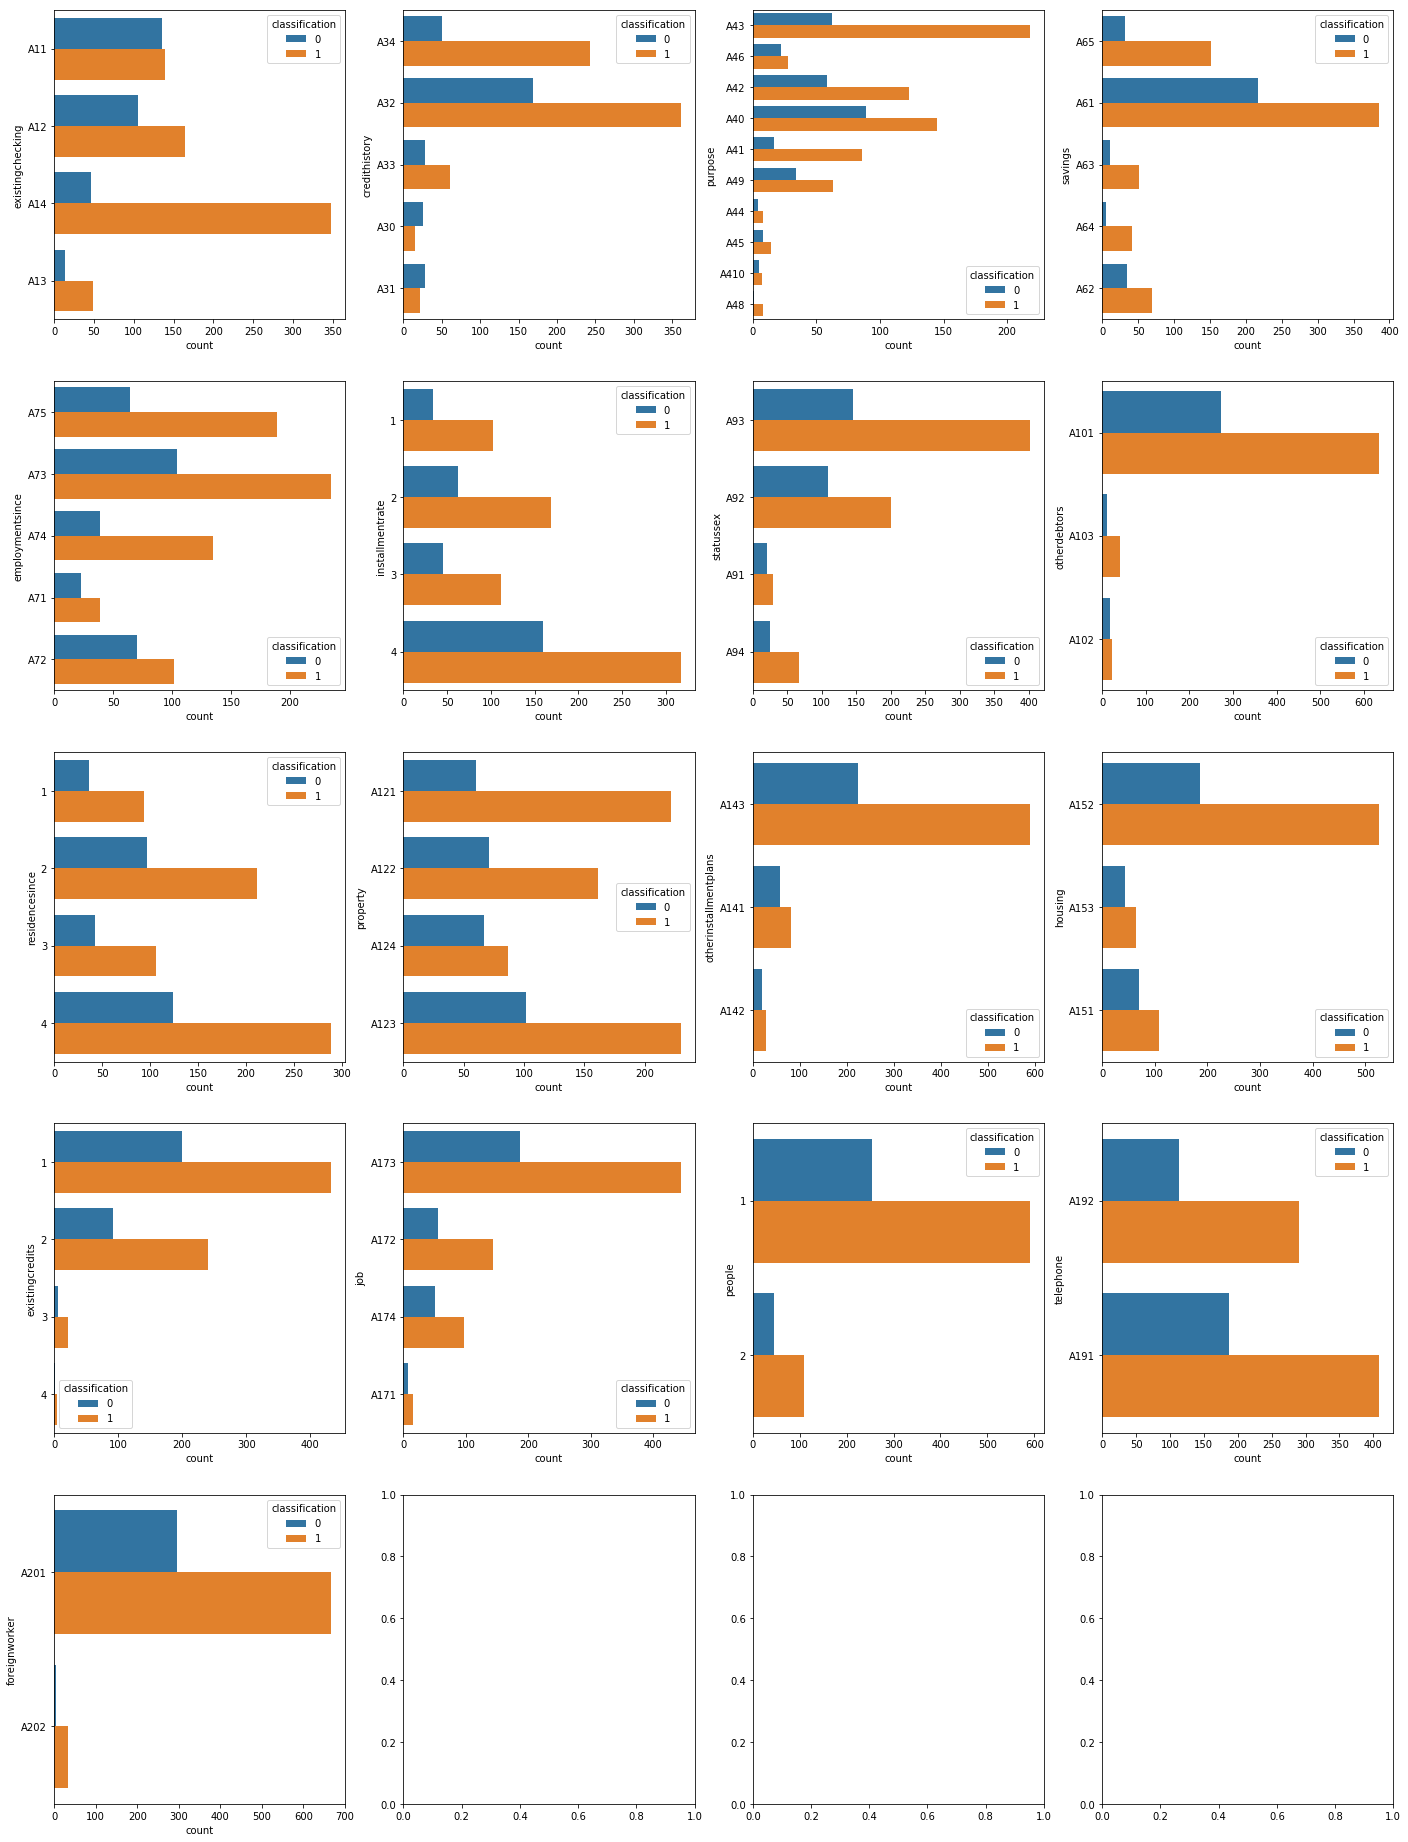

In [7]:
# Histograms for non-continuous attributes
f, axes = plt.subplots(5, 4,figsize=(8*3,11*3))
x=0
y=0

for column in data.drop(['classification','creditamount','duration','age'], axis=1):
    sns.countplot(y=column,
                  hue='classification', 
                  data=data.drop(['creditamount','duration','age'],axis=1), 
                  ax=axes[x,y])
    y+=1
    if y>3:
        x+=1
        y=0
    if x>4:
        break

# Data Transformation

## Numerical Features

In [8]:
# Numerical features range of values
for x in range(len(numvars)):
    print(numvars[x],": ", data[numvars[x]].min()," - ",data[numvars[x]].max())

creditamount :  250  -  18424
duration :  4  -  72
installmentrate :  1  -  4
residencesince :  1  -  4
age :  19  -  75
existingcredits :  1  -  4
people :  1  -  2
classification :  0  -  1


In [9]:
# Standardization
numdata_std = pd.DataFrame(StandardScaler().fit_transform(data[numvars].drop(['classification'], axis=1)))
# MinMax Rescaling to [0,1]
numdata_minmax = pd.DataFrame(MinMaxScaler().fit_transform(data[numvars].drop(['classification'], axis=1)))

D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## Categorical Features

In [10]:
# Labelencoding to transform categorical to numerical
# Enables better Visualization than one hot encoding
d = defaultdict(LabelEncoder)

# Encoding the variable
lecatdata = data[catvars].apply(lambda x: d[x.name].fit_transform(x))

# print transformations
for x in range(len(catvars)):
    print(catvars[x],": ", data[catvars[x]].unique())
    print(catvars[x],": ", lecatdata[catvars[x]].unique())

existingchecking :  ['A11' 'A12' 'A14' 'A13']
existingchecking :  [0 1 3 2]
credithistory :  ['A34' 'A32' 'A33' 'A30' 'A31']
credithistory :  [4 2 3 0 1]
purpose :  ['A43' 'A46' 'A42' 'A40' 'A41' 'A49' 'A44' 'A45' 'A410' 'A48']
purpose :  [4 7 3 0 1 9 5 6 2 8]
savings :  ['A65' 'A61' 'A63' 'A64' 'A62']
savings :  [4 0 2 3 1]
employmentsince :  ['A75' 'A73' 'A74' 'A71' 'A72']
employmentsince :  [4 2 3 0 1]
statussex :  ['A93' 'A92' 'A91' 'A94']
statussex :  [2 1 0 3]
otherdebtors :  ['A101' 'A103' 'A102']
otherdebtors :  [0 2 1]
property :  ['A121' 'A122' 'A124' 'A123']
property :  [0 1 3 2]
otherinstallmentplans :  ['A143' 'A141' 'A142']
otherinstallmentplans :  [2 0 1]
housing :  ['A152' 'A153' 'A151']
housing :  [1 2 0]
job :  ['A173' 'A172' 'A174' 'A171']
job :  [2 1 3 0]
telephone :  ['A192' 'A191']
telephone :  [1 0]
foreignworker :  ['A201' 'A202']
foreignworker :  [0 1]


In [11]:
# One hot encoding
#create dummy variables for every category of every categorical variable
dummyvars = pd.get_dummies(data[catvars])

## Concat Transformed Datasets

In [12]:
# append the dummy variable of the initial numerical variables numvars
data_clean = pd.concat([data[numvars], dummyvars], axis = 1)
data_std = pd.concat([numdata_std, data['classification'], dummyvars], axis = 1)
data_minmax = pd.concat([numdata_minmax, data['classification'], dummyvars], axis = 1)
print(data_clean.shape)
print(data_std.shape)
print(data_minmax.shape)

(1000, 62)
(1000, 62)
(1000, 62)


# Modeling

## Preparation

### Train-test Split

In [13]:
# Unscaled, unnormalized data
X_clean = data_clean.drop('classification', axis=1)
y_clean = data_clean['classification']
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean,y_clean,test_size=0.25, random_state=1)

# Standardized data
X_std = data_std.drop('classification', axis=1)
y_std = data_std['classification']
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_std,y_std,test_size=0.25, random_state=1)

# Rescaled data
X_minmax = data_minmax.drop('classification', axis=1)
y_minmax = data_minmax['classification']
X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax = train_test_split(X_minmax,y_minmax,test_size=0.25, random_state=1)

### Handling Imbalanced Data

In [14]:
# Apply SMOTE
sm = SMOTE(ratio='auto')
X_train_clean_res, y_train_clean_res = sm.fit_sample(X_train_clean, y_train_clean)
X_train_std_res, y_train_std_res = sm.fit_sample(X_train_std, y_train_std)
X_train_minmax_res, y_train_minmax_res = sm.fit_sample(X_train_minmax, y_train_minmax)

# Print number of 'good' credits and 'bad credits, should be fairly balanced now
print("Before/After clean")
unique, counts = np.unique(y_train_clean, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_train_clean_res, return_counts=True)
print(dict(zip(unique, counts)))
print("Before/After std")
unique, counts = np.unique(y_train_std, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_train_std_res, return_counts=True)
print(dict(zip(unique, counts)))
print("Before/After minmax")
unique, counts = np.unique(y_train_minmax, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_train_minmax_res, return_counts=True)
print(dict(zip(unique, counts)))

Before/After clean
{0: 226, 1: 524}
{0: 524, 1: 524}
Before/After std
{0: 226, 1: 524}
{0: 524, 1: 524}
Before/After minmax
{0: 226, 1: 524}
{0: 524, 1: 524}


## Model

In [15]:
# Function for evaluation reports
def get_eval(clf, X_train, y_train,y_test,y_pred):
    # Cross Validation to test and anticipate overfitting problem
    scores1 = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
    scores2 = cross_val_score(clf, X_train, y_train, cv=10, scoring='precision')
    scores3 = cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc')
    # The mean score and standard deviation of the score estimate
    print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std()))
    print("Cross Validation Precision: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std()))
    print("Cross Validation roc_auc: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std()))
    # Create and print confusion matrix
    clf_cm = confusion_matrix(y_test,y_pred)
    print(clf_cm)
    return

### Logistic Regression

In [16]:
# fit, train and cross validate Decision Tree with training and test data 
def logregclf(X_train, y_train,X_test, y_test):
    print("LogisticRegression")
    logreg = LogisticRegression().fit(X_train, y_train)

    # Predict target variables y for test data
    y_pred = logreg.predict(X_test)

    # Get Cross Validation and Confusion matrix
    get_eval(logreg, X_train, y_train,y_test,y_pred)
    return

In [17]:
# Logistic Regression
print("clean resampled")
logregclf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

clean resampled
LogisticRegression


D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklea

Cross Validation Accuracy: 0.81 (+/- 0.11)
Cross Validation Precision: 0.83 (+/- 0.17)
Cross Validation roc_auc: 0.90 (+/- 0.10)
[[ 34  40]
 [ 22 154]]


D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklea

### Decision Tree

In [18]:
# fit, train and cross validate Decision Tree with training and test data 
def dectreeclf(X_train, y_train,X_test, y_test):
    print("DecisionTreeClassifier")
    dec_tree = DecisionTreeClassifier(min_samples_split=10,min_samples_leaf=5).fit(X_train, y_train)

    # Predict target variables y for test data
    y_pred = dec_tree.predict(X_test)

    # Export visualization as file
    #visualize_tree(dec_tree,X_train,y_train)
    
    # Get Cross Validation and Confusion matrix
    get_eval(dec_tree, X_train, y_train,y_test,y_pred)
    return

In [19]:
# Decisiontree
print("clean resampled")
dectreeclf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

clean resampled
DecisionTreeClassifier
Cross Validation Accuracy: 0.76 (+/- 0.11)
Cross Validation Precision: 0.81 (+/- 0.17)
Cross Validation roc_auc: 0.83 (+/- 0.13)
[[ 30  44]
 [ 37 139]]


## Improvements

### Feature Selection using RFE (Recursive Feature Elimination)

RFE is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from the current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.
RFE in sklearn : https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE

#### Logistic Regression

In [20]:
rfe = RFE(LogisticRegression(), 50)
fit = rfe.fit(X_train_clean_res, y_train_clean_res)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

# Apply fitted transformation to datasets
RFEX_train_logres = rfe.transform(X_train_clean_res)
RFEX_test_logres = rfe.transform(X_test_clean)

Num Features: 50
Selected Features: [False False  True False False  True  True  True  True  True  True  True
 False  True  True  True False  True  True  True  True  True False False
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
 False  True  True  True  True  True  True  True  True  True  True  True
  True]
Feature Ranking: [12  9  1  8 11  1  1  1  1  1  1  1  5  1  1  1 10  1  1  1  1  1  3  4
  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  6
  7  1  1  1  1  1  1  1  1  1  1  1  1]


D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklea

In [21]:
print("RFE")
logregclf(RFEX_train_logres, y_train_clean_res, RFEX_test_logres, y_test_clean)

RFE
LogisticRegression


D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklea

Cross Validation Accuracy: 0.80 (+/- 0.13)
Cross Validation Precision: 0.82 (+/- 0.19)
Cross Validation roc_auc: 0.90 (+/- 0.11)
[[ 33  41]
 [ 22 154]]


D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#### Random Forest

In [22]:
# fit, train and cross validate Decision Tree with training and test data 
def randomforestclf(X_train, y_train,X_test, y_test):
    print("RandomForestClassifier")
    randomforest = RandomForestClassifier().fit(X_train, y_train)

    # Predict target variables y for test data
    y_pred = randomforest.predict(X_test)

    # Get Cross Validation and Confusion matrix
    get_eval(randomforest, X_train, y_train,y_test,y_pred)
    return

In [23]:
rfe = RFE(RandomForestClassifier(), 50)
fit = rfe.fit(X_train_clean_res, y_train_clean_res)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

# Apply fitted transformation to datasets
RFEX_train_ranfor = rfe.transform(X_train_clean_res)
RFEX_test_ranfor = rfe.transform(X_test_clean)

D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 

Num Features: 50
Selected Features: [ True  True  True  True  True  True  True  True  True  True  True False
 False  True  True  True  True  True False  True  True False False  True
 False  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True  True  True False
 False]
Feature Ranking: [ 1  1  1  1  1  1  1  1  1  1  1  4  2  1  1  1  1  1 10  1  1 11  8  1
 12  1  1  1  1  1  1  1  1  1  1  1  6  1  1  1  1  5  1  1  1  1  1  1
  1  1  1  1  1  7  1  1  1  1  1  9  3]


In [24]:
# Random Forest
randomforestclf(RFEX_train_ranfor, y_train_clean_res, RFEX_test_ranfor, y_test_clean)

D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier
Cross Validation Accuracy: 0.79 (+/- 0.11)
Cross Validation Precision: 0.85 (+/- 0.14)
Cross Validation roc_auc: 0.89 (+/- 0.12)
[[ 40  34]
 [ 37 139]]


# Conclusion

Before and after feature selection process, the better classification model is from tree model : Decision Tree and Random Forest.